## Imports

In [81]:
"""------------SECTION IMPORTS---------------------"""
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
import joblib
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm


# Define search space for number of trees in random forest and depth of trees
num_trees_min = 64
num_trees_max = 128

depth_min = 2
depth_max = 7

# Useful functions

In [82]:
# Function that returns every possible subset (except the empty set) of the input list l
def subsets(l: object) -> object:
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list

# Import data
NaN data needs to be dropped for RF to work
1. I drop the columns which have NaN values which is all the new data
2. I create a new dataframe which has no columns containing NaN values
3. Copy the `next_prevalence` column to this dataframe and once again drop rows containing NaN

In [83]:
df = pd.read_csv("data/no_missings_sy.csv")
df = df.drop("Unnamed: 0",axis=1)
df.head()

,date,district,prevalence,next_prevalence,prevalence_6lag,ndvi,ipc,population,month,district_encoded,increase
0,2018-01-01,Burco,0.2028,0.221137,0.335941,0.185000,0.05,534884.895,1,21,True
1,2018-01-01,Xudur,0.4862,0.468902,0.486200,0.248333,0.14,113853.105,1,77,False
2,2018-01-01,Bossaso,0.3432,0.482211,0.416056,0.148333,0.01,316531.980,1,18,True
3,2018-01-01,Cadale,0.3510,0.282920,0.369200,0.226667,0.00,48461.805,1,27,False
4,2018-01-01,Qoryooley,0.3510,0.436380,0.369200,0.346667,0.09,196309.485,1,65,True


In [84]:
len(df.district_encoded.unique())

69

## RF-CV

In [85]:
'''------------SECTION RANDOM FOREST CROSS VALIDATION--------------'''
# WARNING: this process can take some time, since there are a lot of hyperparameters to investigate. The search space can be manually reduced to speed up the process.

# Create empty list to store model scores
parameter_scores = []

# Define target and explanatory variables
X = df.select_dtypes(exclude=["category","object"]).drop(["increase", "prevalence", "next_prevalence"],axis=1)
y = df['next_prevalence'].values

In [86]:
X.head()

,prevalence_6lag,ndvi,ipc,population,month,district_encoded
0,0.335941,0.185000,0.05,534884.895,1,21
1,0.486200,0.248333,0.14,113853.105,1,77
2,0.416056,0.148333,0.01,316531.980,1,18
3,0.369200,0.226667,0.00,48461.805,1,27
4,0.369200,0.346667,0.09,196309.485,1,65


In [87]:
y[:5]

array([0.22113668, 0.4689021 , 0.48221061, 0.28292017, 0.43637985])

# Train-test split

In [88]:
# First 5 observations
train_split = 345

386

In [89]:
for num_trees in tqdm(range(num_trees_min, num_trees_max)):

    for depth in range(depth_min, depth_max):

        # Investigate every subset of explanatory variables
        # noinspection PyTypeChecker
        for features in subsets(X.columns):
            # First CV split. The 207 refers to the first 3 observations for the 69 districts in the data.
            #
            Xtrain = X[:207][features].copy().values
            ytrain = y[:207]
            Xtest = X[207:][features].copy().values
            ytest = y[207:]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0, n_jobs=-1)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE1 = mean_absolute_error(ytest, predictions)

            # Second CV split. The 276 refers to the first 4 observations for the 69 districts in the data.
            Xtrain = X[:276][features].copy().values
            ytrain = y[:276]
            Xtest = X[276:][features].copy().values
            ytest = y[276:]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0, n_jobs=-1)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE2 = mean_absolute_error(ytest, predictions)

            # Calculate the mean MAE over the two folds
            mean_MAE = (MAE1 + MAE2) / 2

            # Store the mean MAE together with the used hyperparameters in list
            parameter_scores.append((mean_MAE, num_trees, depth, features))

# Sort the models based on score and retrieve the hyperparameters of the best model
parameter_scores.sort(key=lambda x: x[0])
best_model_score = parameter_scores[0][0]
best_model_trees = parameter_scores[0][1]
best_model_depth = parameter_scores[0][2]
best_model_columns = list(parameter_scores[0][3])

'''------------SECTION FINAL EVALUATION--------------'''
X = df[best_model_columns].values
y = df['next_prevalence'].values

# If there is only one explanatory variable, the values need to be reshaped for the model
if len(best_model_columns) == 1:
    X = X.reshape(-1, 1)

# Perform evaluation on full data
Xtrain = X[:345]
ytrain = y[:345]
Xtest = X[345:]
ytest = y[345:]

clf = RandomForestRegressor(n_estimators=best_model_trees, max_depth=best_model_depth, random_state=0, n_jobs=-1)
clf.fit(Xtrain, ytrain)
predictions = clf.predict(Xtest)

len(predictions)

100%|██████████| 64/64 [18:06<00:00, 16.97s/it]


138

## Fix `prevalence` on line 5 in the next code block

In [90]:
# Calculate MAE
MAE = mean_absolute_error(ytest, predictions)

# Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase = [0 if x < y else 1 for x in df.iloc[345:]['next_prevalence'] for y in df.iloc[345:]['prevalence']]
predicted_increase = [0 if x < y else 1 for x in predictions for y in df.iloc[345:]['prevalence']]
len(increase), len(predicted_increase)

19044

In [93]:
# Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)

# Print model parameters
print('no. of trees: ' + str(best_model_trees) + '\nmax_depth: ' + str(best_model_depth) + '\ncolumns: ' + str(
    best_model_columns))

# Print model scores
print(MAE, acc)

no. of trees: 122
max_depth: 2
columns: ['prevalence_6lag', 'ndvi', 'ipc']
0.05757971682130712 0.8398970804452845


# Save model

In [94]:
filename = 'baseline_semiyearly_model.joblib'
joblib.dump(clf, filename)

['baseline_semiyearly_model.joblib']

# Metrics

In [95]:
from helper_metrics import make_confusion_matrix, roc_curve_gen, calculate_results

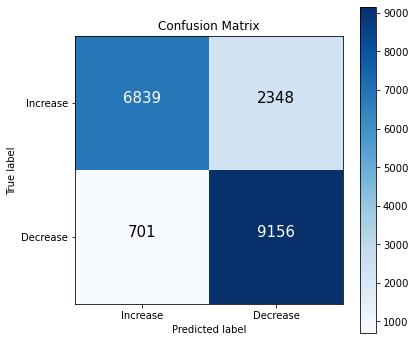

In [96]:
make_confusion_matrix(increase, predicted_increase,figsize=(6,6),classes=["Increase", "Decrease"], cmap=plt.cm.Greens)

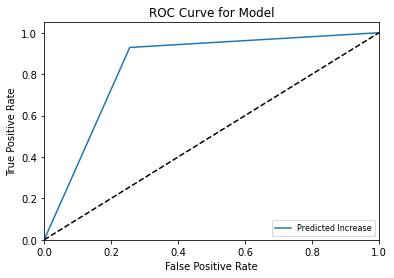

In [97]:
roc_curve_gen(increase, predicted_increase)

In [98]:
calculate_results(increase, predicted_increase, average="weighted")

{'accuracy': 83.98970804452846,
 'precision': 0.8495082212840828,
 'recall': 0.8398970804452845,
 'f1': 0.8381871468399069}